
# Analysis of the tgbl-review-v2 dataset

This notebook explores the tgbl-review-v2 dataset

### Dataset Preparation

In [34]:
from TGB.tgb.linkproppred.dataset import LinkPropPredDataset
import pandas as pd

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name = "tgbl-review"
dataset = LinkPropPredDataset(name=name, root="./Datasets", preprocess=True)
data = dataset.full_data

data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps']]).T
data_df.columns = ['Source', 'Destination', 'Timestamp']

raw file found, skipping download
Dataset directory is  /opt/homebrew/lib/python3.11/site-packages/tgb/./Datasets/tgbl_review
loading processed file


In [3]:
data_df

,Source,Destination,Timestamp
0,0.0,1.0,9.292320e+08
1,2.0,3.0,9.307872e+08
2,4.0,1.0,9.318240e+08
3,5.0,6.0,9.318240e+08
4,7.0,8.0,9.318240e+08
...,...,...,...
4873535,257355.0,234180.0,1.538438e+09
4873536,195919.0,301073.0,1.538525e+09
4873537,143936.0,137681.0,1.538525e+09
4873538,70003.0,249788.0,1.538611e+09


### Dataset Analysis

<Axes: >

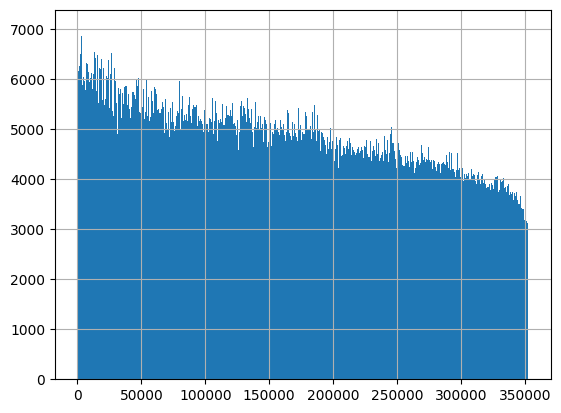

In [4]:
data_df['Source'].hist(bins=1000)

<Axes: >

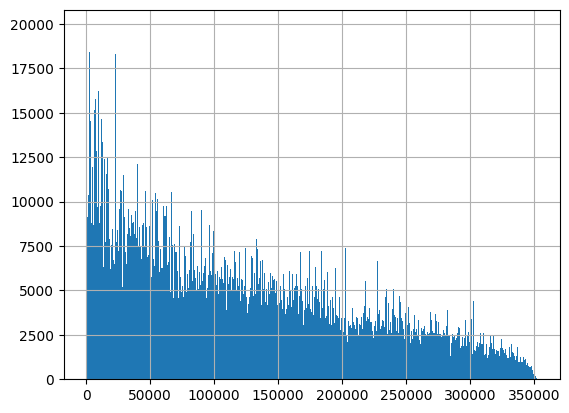

In [5]:
data_df['Destination'].hist(bins=1000)

<Axes: >

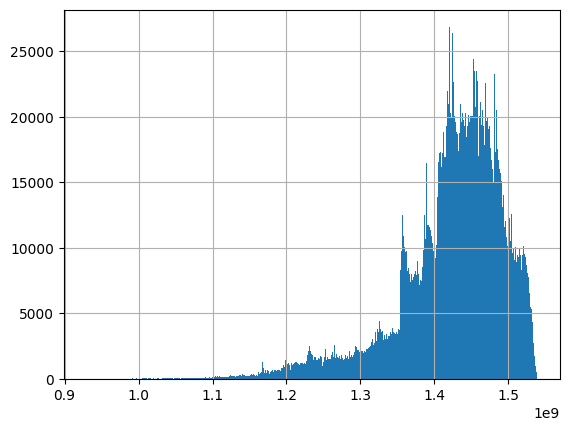

In [6]:
data_df['Timestamp'].hist(bins=1000)

Cumulative distribution function of unique users

In [36]:
import matplotlib.pyplot as plt

def plot_cdf(data_df, column_name, log_scale=False, title='CDF Plot', xlabel='Value', ylabel='CDF'):
    if column_name not in data_df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    sorted_df = data_df.sort_values(by=column_name).reset_index(drop=True)
    sorted_df['cdf'] = sorted_df[column_name].rank(method='average', pct=True)

    plt.figure(figsize=(8, 6))
    plt.plot(sorted_df[column_name], sorted_df['cdf'], marker='.', linestyle='none')

    if log_scale:
        plt.xscale('log')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.show()

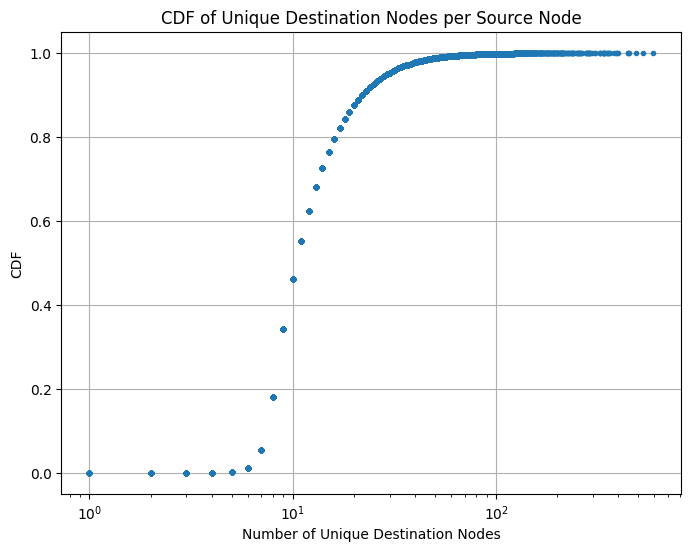

In [8]:
dest_counts_per_source = data_df.groupby('Source')['Destination'].nunique()
dest_counts_df = dest_counts_per_source.reset_index(name='UniqueDestCount')

plot_cdf(dest_counts_df, 'UniqueDestCount', log_scale=True, title='CDF of Unique Destination Nodes per Source Node', xlabel='Number of Unique Destination Nodes', ylabel='CDF')

<Axes: >

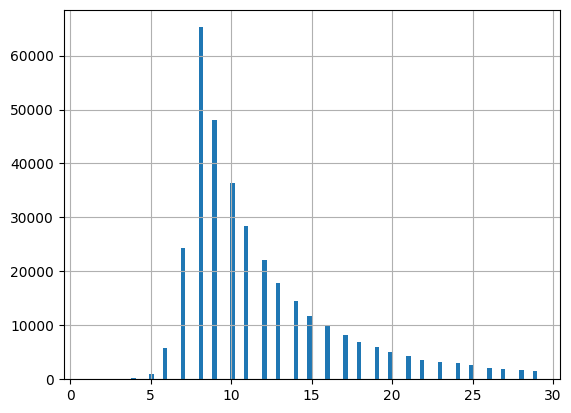

In [9]:
filtered_series = dest_counts_per_source[(dest_counts_per_source >= 1) & (dest_counts_per_source < 30)]

filtered_series.hist(bins=100)

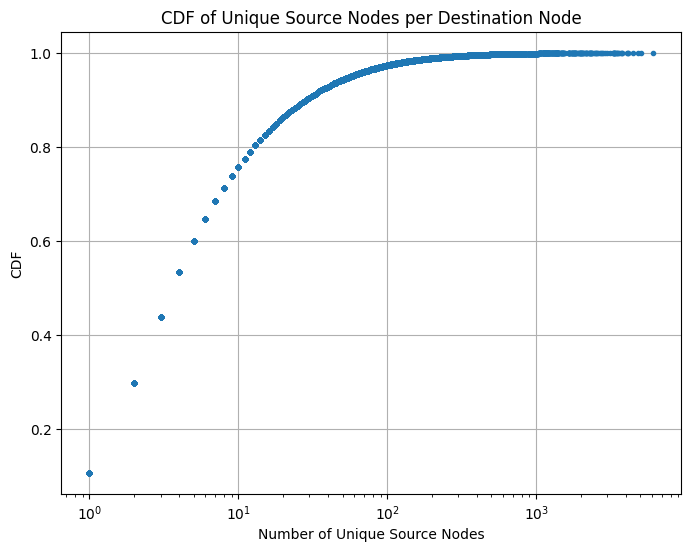

In [10]:
dest_counts_per_destination = data_df.groupby('Destination')['Source'].nunique()
dest_counts_df = dest_counts_per_destination.reset_index(name='UniqueSourceCount')

plot_cdf(dest_counts_df, 'UniqueSourceCount', log_scale=True, title='CDF of Unique Source Nodes per Destination Node', xlabel='Number of Unique Source Nodes', ylabel='CDF')

<Axes: >

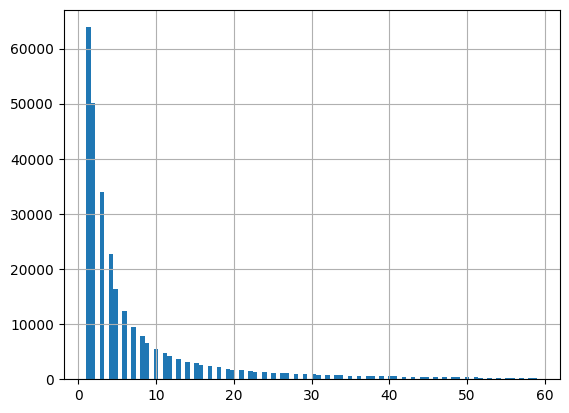

In [11]:
filtered_series = dest_counts_per_destination[(dest_counts_per_destination >= 1) & (dest_counts_per_destination < 60)]

filtered_series.hist(bins=100)

Number of interactions for pairs between source and destination

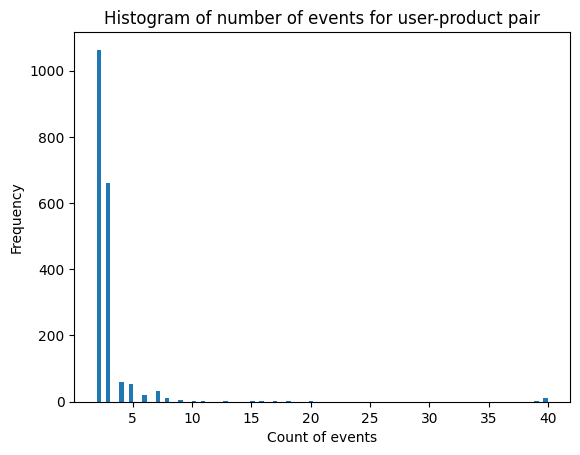

In [21]:
data_df['TimeDiff'] = data_df.groupby(['Source', 'Destination'])['Timestamp'].diff().dropna()

periodicity_metrics = data_df.groupby(['Source', 'Destination'])['TimeDiff'].agg(['mean', 'std', 'count']).dropna()
periodicity_metrics.sort_values(by='count', inplace=True)

periodicity_metrics['count'].hist(bins=100)

plt.title('Histogram of number of events for user-product pair')
plt.xlabel('Count of events')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

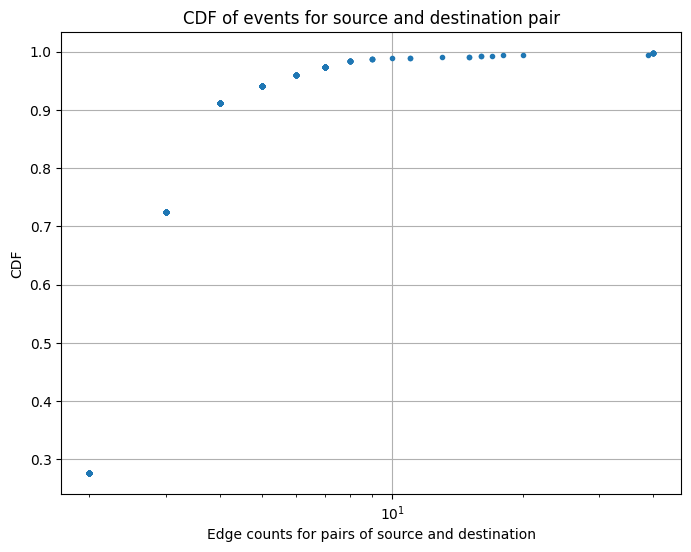

In [22]:
periodicity_metrics_count = periodicity_metrics['count']

dest_counts_df = periodicity_metrics_count.reset_index(name='UserProductCount')

plot_cdf(dest_counts_df, 'UserProductCount', log_scale=True, title='CDF of events for source and destination pair', xlabel='Edge counts for pairs of source and destination', ylabel='CDF')

In [23]:
print(f'Periodicity metrics mean count {round(periodicity_metrics_count.mean(), 2)}')
print(f'Periodicity metrics median count {periodicity_metrics_count.median()}')
print(f'Periodicity metrics max count {periodicity_metrics_count.max()}')
print(f'Periodicity metrics max count {periodicity_metrics_count.min()}')

Periodicity metrics mean count 2.95
Periodicity metrics median count 2.0
Periodicity metrics max count 40
Periodicity metrics max count 2


Plot interactions between source and destination pairs

In [28]:
import numpy as np

def plot_histogram_for_source_destination_pairs(data_df, max_pairs=None, bins=50, logscale= True, inc_rand = True):
    grouped = data_df.groupby(['Source', 'Destination'])

    plt.figure(figsize=(10, 6))

    pair_count = 0

    for (source, destination), group in grouped:

        time_diffs = group['TimeDiff'].dropna()
        latest_time = group['Timestamp'][-1:]

        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue

        positive_time_diffs = group['TimeDiff'][group['TimeDiff'] > 0]

        if logscale:

            log_time_diffs = np.log(positive_time_diffs)
            plt.hist(log_time_diffs, bins=bins, label=f'Source {source} to Dest {destination}', alpha=0.75)
        else:
            plt.hist(positive_time_diffs, bins=bins, label=f'Source {source} to Dest {destination}', alpha=0.75)

        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if inc_rand:
        plt.hist(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins,
                 label=f'Random',
                 alpha=0.75)



    plt.xlabel('Log(Time Difference)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Log-Scaled Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

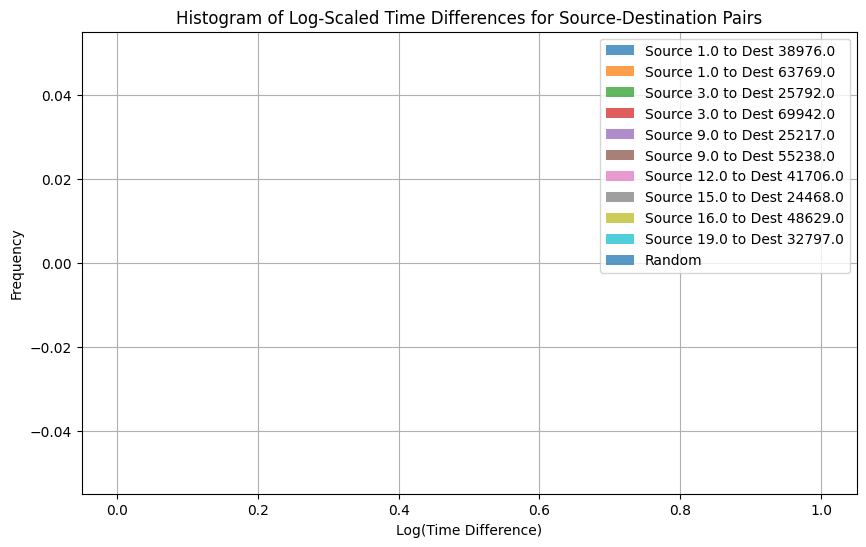

In [32]:
plot_histogram_for_source_destination_pairs(data_df, max_pairs=10, bins=50, logscale=False)

In [47]:
def plot_cdf_for_source_destination_pairs(data_df, max_pairs=None, log_scale=False):
    grouped = data_df.groupby(['Source', 'Destination'])
    plt.figure(figsize=(10, 6))

    pair_count = 0

    for (source, destination), group in grouped:
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue

        sorted_time_diffs = np.sort(group['TimeDiff'].dropna().values)
        cdf = np.arange(1, len(sorted_time_diffs) + 1) / len(sorted_time_diffs)

        if (sorted_time_diffs[0] > 0.01):
            plt.plot(sorted_time_diffs, cdf, label=f'Source {source} to Dest {destination}')

        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break


    if log_scale:
        plt.xscale('log')

    plt.xlabel('Time Difference')
    plt.ylabel('CDF')
    plt.title('CDF of Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

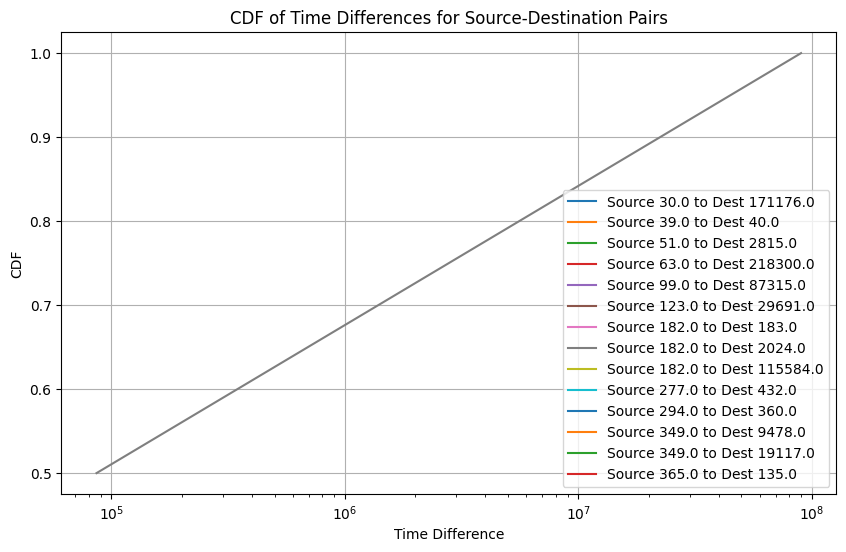

In [48]:
plot_cdf_for_source_destination_pairs(data_df, max_pairs=200, log_scale=True)

In [60]:
from matplotlib.lines import Line2D

def plot_edges_over_time_by_source(data_df, source_subset):
    filtered_data = data_df[data_df['Source'].isin(source_subset)].copy()

    filtered_data.sort_values(by='Timestamp', inplace=True)

    _, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.jet(np.linspace(0, 1, len(source_subset)))

    color_map = {source: color for source, color in zip(source_subset, colors)}

    for (source, destination), group in filtered_data.groupby(['Source', 'Destination']):
        ax.scatter(group['Timestamp'], [destination] * len(group), color=color_map[source], label=source, alpha=0.5)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=source,
                              markerfacecolor=color, markersize=10)
                       for source, color in color_map.items()]
    ax.legend(handles=legend_elements, title="Source Nodes", bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Destination Node')
    ax.set_title('Edges Over Time by Source Node')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

source_subset = np.arange(1000, 1100, 1)

/var/folders/j9/gr3m7ly52mx4hfzpzdtzzfg40000gn/T/ipykernel_7735/2643315856.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


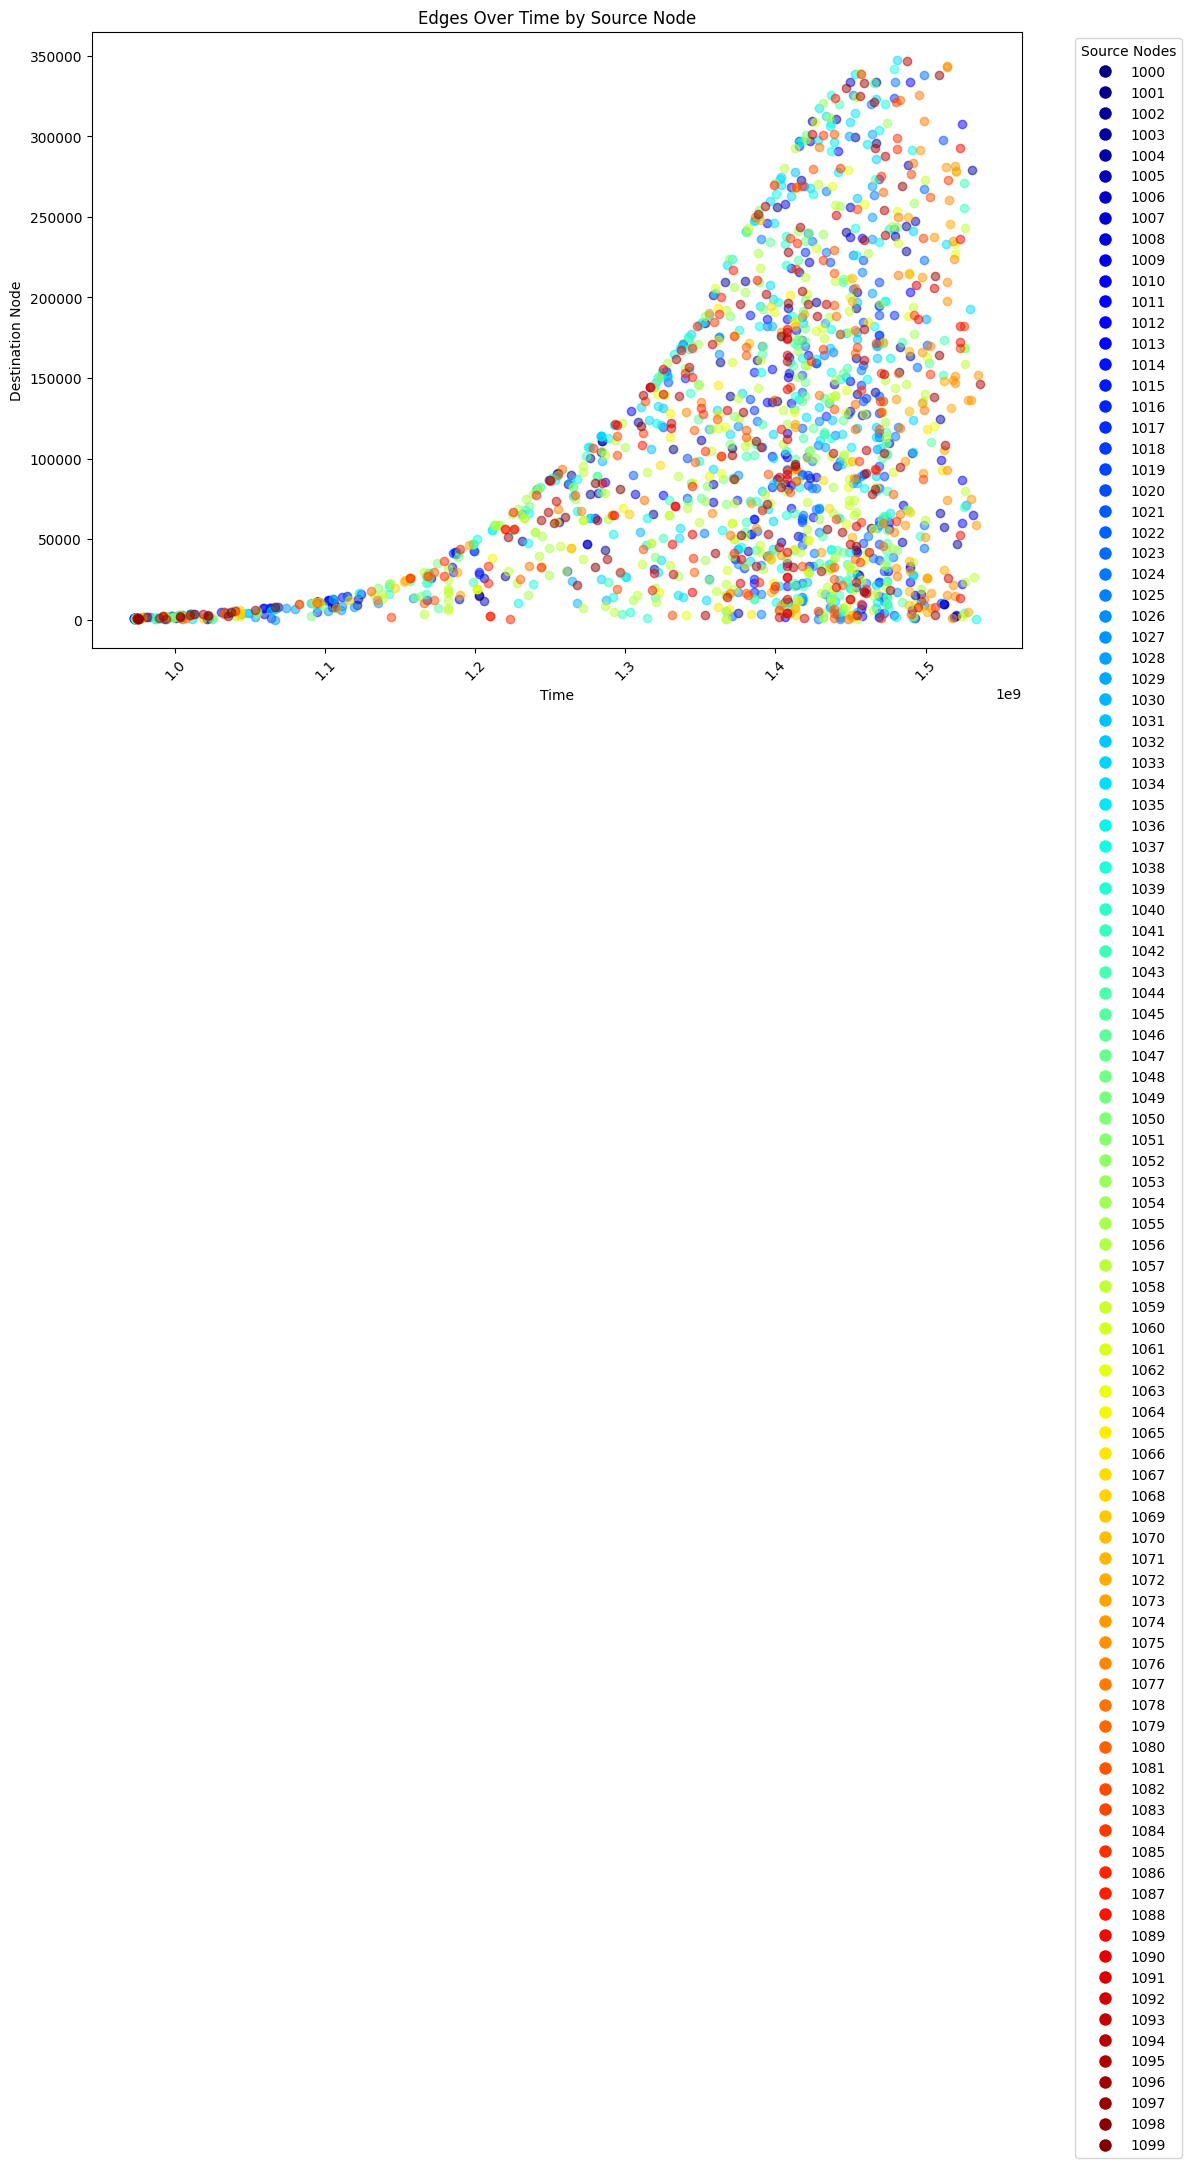

In [ ]:
plot_edges_over_time_by_source(data_df, source_subset)

In [49]:
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

def compute_distances(data_df):
    grouped = data_df.groupby(['Source', 'Destination'])

    results = []

    for (source, destination), group in grouped:
        time_diffs = group['TimeDiff'].dropna()
        count = len(time_diffs) + 1
        latest_time = group['Timestamp'][-1:]
        if time_diffs.empty:
            continue

        bins = int(len(time_diffs))

        counts_p, _ = np.histogram(time_diffs, bins=bins, density=True)
        try:
            p = counts_p/sum(counts_p)

            counts_q, _ = np.histogram(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins)
            q = counts_q / sum(counts_q)


            tv_distance = total_variation_distance(p, q)
            hellinger = hellinger_distance(p, q)

            results.append({
                'Source': source,
                'Destination': destination,
                'Count': count,
                'Total Variation Distance': tv_distance,
                'Hellinger Distance': hellinger
            })
        except:
            continue

    results_df = pd.DataFrame(results)

    return results_df

In [50]:
results_df = compute_distances(data_df)

/var/folders/j9/gr3m7ly52mx4hfzpzdtzzfg40000gn/T/ipykernel_30150/1640102885.py:26: RuntimeWarning: invalid value encountered in divide
  q = counts_q / sum(counts_q)


In [53]:
results_df = results_df.dropna()

In [54]:
results_df = results_df[results_df['Count'] > 1]

In [55]:
results_df

,Source,Destination,Count,Total Variation Distance,Hellinger Distance
85,182.0,2024.0,3,0.500000,0.541196
94,192.0,2326.0,4,1.000000,1.000000
102,207.0,316551.0,3,0.500000,0.541196
149,305.0,2102.0,3,0.000000,0.000000
184,349.0,54285.0,4,0.166667,0.120006
...,...,...,...,...,...
139283,350517.0,93839.0,3,0.500000,0.541196
139427,351590.0,101136.0,3,0.000000,0.000000
139456,351765.0,93681.0,4,1.000000,1.000000
139480,351921.0,38486.0,4,1.000000,1.000000


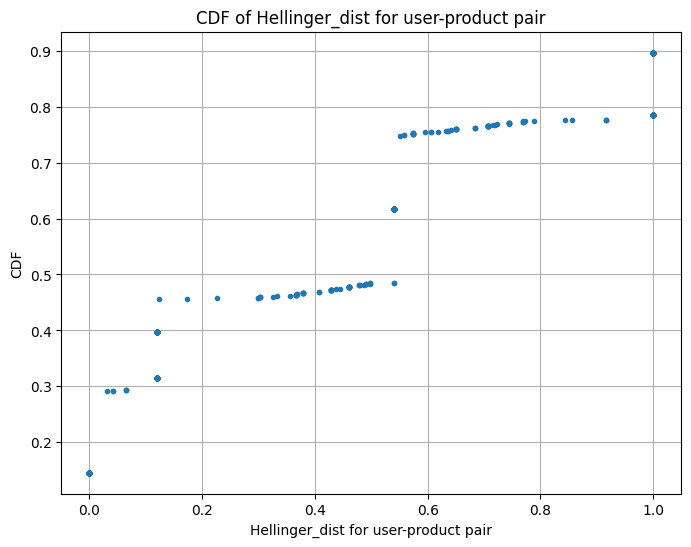

In [56]:
Hellinger_dist = results_df['Hellinger Distance']

dest_counts_df = Hellinger_dist.reset_index(name='Hellinger_dist')

plot_cdf(dest_counts_df, 'Hellinger_dist', log_scale=False, title='CDF of Hellinger_dist for user-product pair', xlabel='Hellinger_dist for user-product pair', ylabel='CDF')

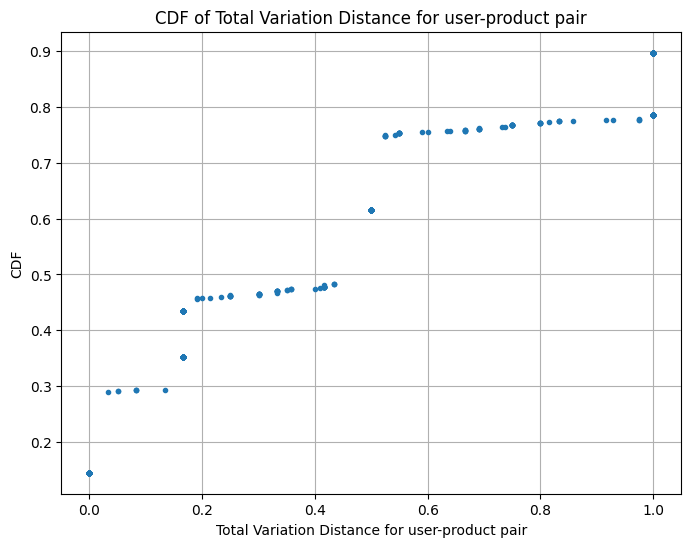

In [57]:
Total_Variation_Distance = results_df['Total Variation Distance']

dest_counts_df = Total_Variation_Distance.reset_index(name='Total Variation Distance')

plot_cdf(dest_counts_df, 'Total Variation Distance', log_scale=False, title='CDF of Total Variation Distance for user-product pair', xlabel='Total Variation Distance for user-product pair', ylabel='CDF')

/var/folders/j9/gr3m7ly52mx4hfzpzdtzzfg40000gn/T/ipykernel_30150/3412219963.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


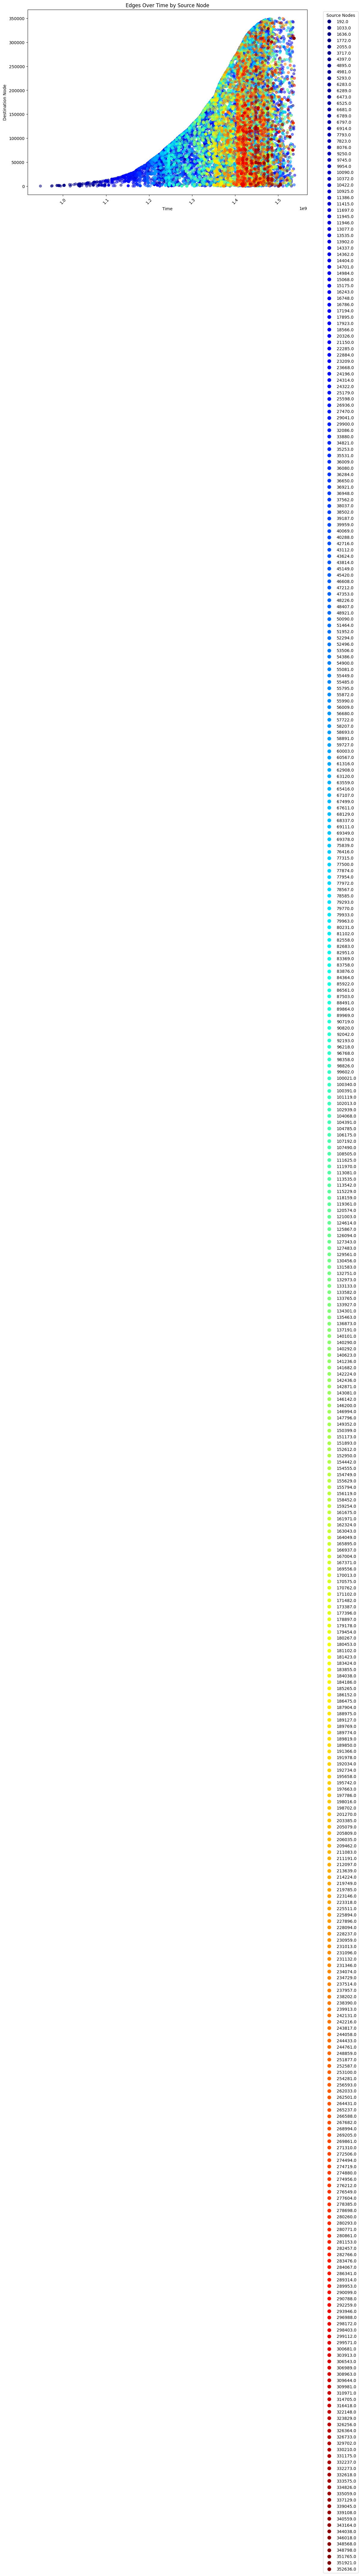

In [61]:
filtered_results_df = results_df[results_df['Total Variation Distance'] >0.9]
source_subset = filtered_results_df['Source'].unique()

plot_edges_over_time_by_source(data_df, source_subset)

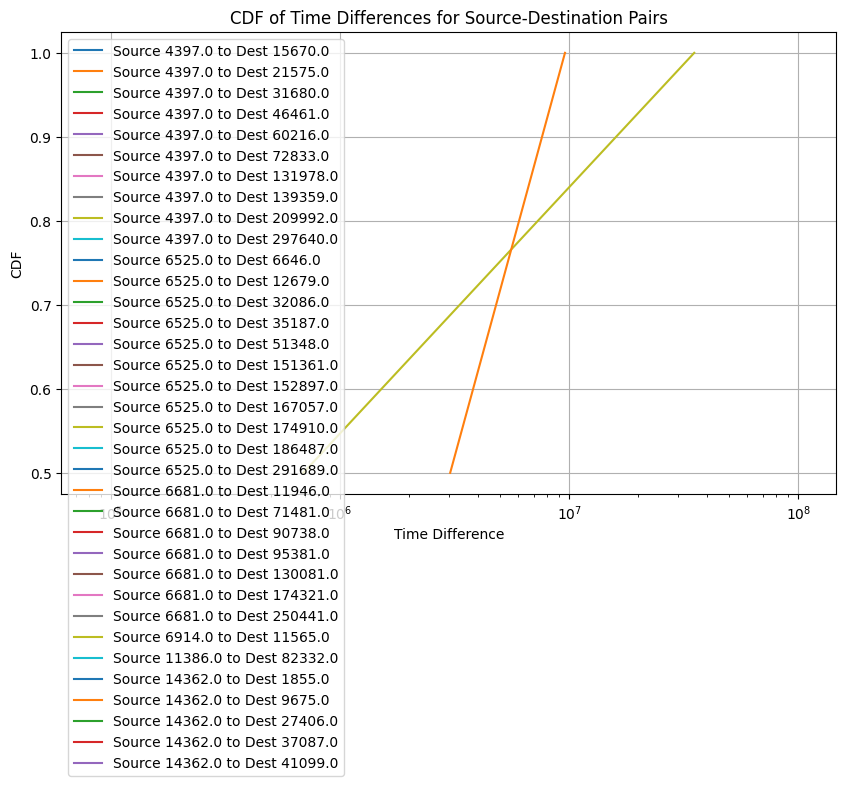

In [70]:
filtered_data_df = data_df[data_df['Source'].isin(source_subset)].dropna()

plot_cdf_for_source_destination_pairs(filtered_data_df, max_pairs=200, log_scale=True)

### Observing recurrency patterns in the dataset

The code below is taken and adjusted from [DGB](https://github.com/fpour/DGB/tree/main)

In [43]:
def process_edgelist_per_timestamp(temp_edgelist):
    unique_ts = list(temp_edgelist.keys())
    print(f"There are {len(unique_ts)} timestamps.")

    node_dict = {}
    for t, e_dict in temp_edgelist.items():
        for e, exist in e_dict.items():
            if e[0] not in node_dict:
                node_dict[e[0]] = 1
            if e[1] not in node_dict:
                node_dict[e[1]] = 1
    num_nodes = len(node_dict)
    num_e_fully_connected = num_nodes * (num_nodes - 1)

    edge_frequency_dict = {}
    ts_edges_dist = []
    ts_edges_dist_density = []
    for curr_t in unique_ts:
        prev_ts = [ts for ts in unique_ts if ts < curr_t]
        edges_in_prev_ts = {}
        for bts in prev_ts:
            edges_in_prev_ts.update(temp_edgelist[bts])

        curr_ts_edge_list = temp_edgelist[curr_t]
        for e in curr_ts_edge_list:
            if e not in edge_frequency_dict:
                edge_frequency_dict[e] = 1
            else:
                edge_frequency_dict[e] += 1

        if len(curr_ts_edge_list) > 0:
            curr_ts_edges_dist = {'ts': curr_t,
                                  'new': len([e for e in curr_ts_edge_list if e not in edges_in_prev_ts]),
                                  'repeated': len([e for e in curr_ts_edge_list if e in edges_in_prev_ts]),
                                  'not_repeated': len([e for e in edges_in_prev_ts if e not in curr_ts_edge_list]),
                                  'total_curr_ts': len(curr_ts_edge_list),
                                  'total_seen_until_curr_ts': len(edges_in_prev_ts) + len(curr_ts_edge_list)
                                  }
            curr_ts_edges_dist_density = {'ts': curr_t,
                                          'new': (curr_ts_edges_dist['new'] * 1.0) / num_e_fully_connected,
                                          'repeated': (curr_ts_edges_dist['repeated'] * 1.0) / num_e_fully_connected,
                                          'not_repeated': (curr_ts_edges_dist[
                                                               'not_repeated'] * 1.0) / num_e_fully_connected,
                                          'total_curr_ts': (curr_ts_edges_dist[
                                                                'total_curr_ts'] * 1.0) / num_e_fully_connected,
                                          'total_seen_until_curr_ts': (curr_ts_edges_dist[
                                                                           'total_seen_until_curr_ts'] * 1.0) / num_e_fully_connected,
                                          }
        else:
            curr_ts_edges_dist = {'ts': curr_t,
                                  'new': 0,
                                  'repeated': 0,
                                  'not_repeated': 0,
                                  'total_curr_ts': 0,
                                  'total_seen_until_curr_ts': len(edges_in_prev_ts) + len(curr_ts_edge_list)
                                  }
            curr_ts_edges_dist_density = {'ts': curr_t,
                                          'new': 0,
                                          'repeated': 0,
                                          'not_repeated': 0,
                                          'total_curr_ts': 0,
                                          'total_seen_until_curr_ts': 0,
                                          }
        ts_edges_dist.append(curr_ts_edges_dist)
        ts_edges_dist_density.append(curr_ts_edges_dist_density)
    return ts_edges_dist, ts_edges_dist_density, edge_frequency_dict

In [44]:
def plot_edges_bar(ts_edges_dist, network_name, USLegis=False):
    ts_edges_dist_df = pd.DataFrame(ts_edges_dist, columns=['ts', 'new', 'repeated',
                                                            'not_repeated',
                                                            'total_curr_ts',
                                                            'total_seen_until_curr_ts'])
    mean = ts_edges_dist_df.mean(axis=0)
    print("INFO: Network Name:", network_name)
    print("INFO: AVG. stats. over all timestamps: ", mean)
    print("INFO: ratio of avg.(new)/avg.(total_curr_ts): {:.2f}".format(mean['new'] / mean['total_curr_ts']))

    fig, ax = plt.subplots(figsize=(7, 5))
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.subplots_adjust(bottom=0.2, left=0.2)
    font_size = 20
    ticks_font_size = 18

    timestamps = ts_edges_dist_df['ts'].tolist()
    if (USLegis):
        timestamps = [int(j) + 97 for j in timestamps]
    if network_name == "Flight Mar to June 2020":
            timestamps = [j[5:] for j in timestamps]

    new = ts_edges_dist_df['new'].tolist()
    repeated = ts_edges_dist_df['repeated'].tolist()

    plt.bar(timestamps, repeated, label='Repeated', color='#404040', alpha=0.4)
    plt.bar(timestamps, new, label='New', bottom=repeated, color='#ca0020', alpha=0.8, hatch='//')
    plt.axvline(x=(timestamps[int(0.85 * len(timestamps))]), color="blue", linestyle="--", linewidth=2)
    plt.text((timestamps[int(0.85 * len(timestamps))]), 0,
             'x', va='center', ha='center', fontsize=font_size, fontweight='heavy', color='blue')

    if isinstance(timestamps[0], str):
        labels = []
        time_gap = 15
        for i in range(len(timestamps)):
            if i % time_gap == 0:
                labels.append(timestamps[i])

        time_gaps = list(range(0, len(timestamps), time_gap))
        plt.xticks(time_gaps, labels, fontsize=ticks_font_size)
        plt.yticks(fontsize=ticks_font_size)

    plt.margins(x=0)
    plt.xlabel("Timestamp", fontsize=font_size)
    plt.ylabel("Number of edges", fontsize=font_size)
    plt.legend()
    plt.savefig(f"figs/{network_name}" + ".pdf")
    plt.close()

In [45]:
def load_continuous_edgelist(fname, interval_size=86400):
    print("Info: Interval size:", interval_size)

    u_idx = 1
    v_idx = 2
    ts_idx = 0

    temporal_edgelist = {}
    total_n_edges = 0
    with open(fname) as f:
        next(f)  # Skip the first line
        for _, line in enumerate(f):
            total_n_edges += 1
            e = line.strip().split(',')
            u = e[u_idx]
            v = e[v_idx]
            ts = float(e[ts_idx])
            ts_bin_id = int(ts / interval_size)
            if ts_bin_id not in temporal_edgelist:
                temporal_edgelist[ts_bin_id] = {}
                temporal_edgelist[ts_bin_id][(u, v)] = 1
            else:
                if (u, v) not in temporal_edgelist[ts_bin_id]:
                    temporal_edgelist[ts_bin_id][(u, v)] = 1
                else:
                    temporal_edgelist[ts_bin_id][(u, v)] += 1

    print("Loading edge-list: Maximum timestamp is ", ts)
    print("Loading edge-list: Maximum timestamp-bin-id is", ts_bin_id)
    print("Loading edge-list: Total number of edges:", total_n_edges)
    return temporal_edgelist

In [46]:
def gen_plot_edge_dist(temp_edgelist, network_name, USLegis):
    ts_edges_dist, ts_edges_dist_density, edge_frequency_dict = process_edgelist_per_timestamp(temp_edgelist)
    plot_edges_bar(ts_edges_dist, network_name, USLegis=USLegis)

In [47]:
def plot_continuous_network(network_name):
    interval_size = 86400  # one day
    edgelist_filename = 'datasets/tgbl-review_edgelist_v2.csv'
    temp_edgelist = load_continuous_edgelist(edgelist_filename, interval_size=interval_size)
    gen_plot_edge_dist(temp_edgelist, network_name, USLegis=False)

Info: Interval size: 86400
Loading edge-list: Maximum timestamp is  1538611200.0
Loading edge-list: Maximum timestamp-bin-id is 17808
Loading edge-list: Total number of edges: 4873540
There are 6865 timestamps.
INFO: Network Name: tgbl-review
INFO: AVG. stats. over all timestamps:  ts                           14374.562272
new                            689.034669
repeated                         1.234960
not_repeated                914451.697451
total_curr_ts                  690.269629
total_seen_until_curr_ts    915143.202039
dtype: float64
INFO: ratio of avg.(new)/avg.(total_curr_ts): 1.00


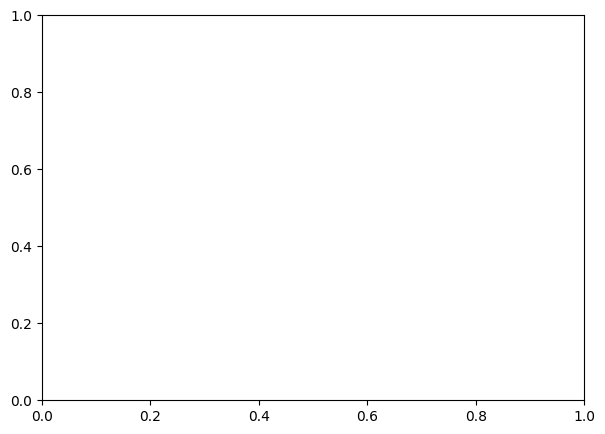

In [48]:
plot_continuous_network("tgbl-review")